# **The Stokes equations - adaptive mesh refinement**
**Jacob Wahlgren**

# **Abstract**

We use FEniCS to solve the Stokes equations using adaptive mesh refinement to examine how different parameters affect the refinement process.

# **About the code**

In [138]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)
# Copyright (C) 2021 Jacob Wahlgren (jacobwah@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [139]:
import numpy as np
import time
from dolfin import *
from mshr import *
import dolfin.common.plotting as fenicsplot
from matplotlib import pyplot as plt

# **Introduction**

The Stokes equations describe flow at small Reynolds numbers. Using more nodes in the approximation space (mesh) improves the accuracy of the soultion but increases the running time. To identify where higher resolution is most beneficial a technique called adaptive mesh refinement can be used.

I solved the following parts of the assignment.

1. The domain: Use the data to the adjoint problem which defines the functional equal to the drag force.
Then change the height of the domain to H=L, and move the center of the circle over the domain. Describe how the adjoint solution and the local mesh refinement changes as a result. 

2. The functinoal: Change the data to the adjoint problem (psi_1, psi_2, psi_3) and describe how the adjoint solution and the local mesh refinement changes as a result.

3. Total error: With the same approximation spaces for the primal and the adjoint problem, note that the total error appears to be close to zero. This is a false conclusion, and a consequence of the fact that we approximate the exact adjoint solution with a finite element function in the test space of the primal problem, for which the weak form is zero (modulo errors from solving the algebraic system). Change the mixed finite element space of the adjoint equation such that the total error is not zero, for example, increase the polynomial order of the adjoint finite element spaces. Then verify that the total error is reduced when you use a mesh with finer resolution.  

# **Method**

**Define domain and mesh**

The domain is square with a circular obstacle inside it.

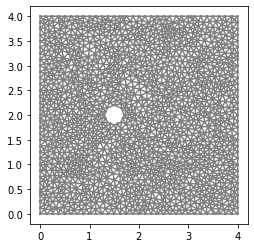

In [140]:
# Define rectangular domain 
L = 4
H = 4

# Define circle
xc = 1.5
yc = 0.5*H
rc = 0.2

# Generate mesh (examples with and without a hole in the mesh) 
resolution = 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Local mesh refinement (specified by a cell marker)
init_no_levels = 0
for i in range(0,init_no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(0.5, 0.5)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

The primal problem is solved in the Taylor-Hood mixed finite element space, and the adjoint problem is solved in a higher degree mixed space of continuous piecewise cubics and quadratics.

In [141]:
# Generate mixed finite element spaces (for primal velocity and pressure)
VE = VectorElement("CG", mesh.ufl_cell(), 2)
QE = FiniteElement("CG", mesh.ufl_cell(), 1)
WE = VE * QE

W = FunctionSpace(mesh, WE)
V = FunctionSpace(mesh, VE)
Q = FunctionSpace(mesh, QE)

# Define trial and test functions
w = Function(W)
(u, p) = (as_vector((w[0],w[1])), w[2])
(v, q) = TestFunctions(W) 

# Generate mixed finite element spaces (for adjoint velocity and pressure)
VEa = VectorElement("CG", mesh.ufl_cell(), 3)
QEa = FiniteElement("CG", mesh.ufl_cell(), 2)
WEa = VEa * QEa

Wa = FunctionSpace(mesh, WEa)
Va = FunctionSpace(mesh, VEa)
Qa = FunctionSpace(mesh, QEa)

# Define adjoint trial and test functions
wa = Function(Wa)
(phi, theta) = (as_vector((wa[0],wa[1])), wa[2])
(va, qa) = TestFunctions(Wa)

**Define boundary conditions**

In [142]:
# Examples of inflow and outflow conditions
XMIN = 0.0; XMAX = L
YMIN = 0.0; YMAX = H
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) 
#pout = 0.0

# Inflow boundary (ib), outflow boundary (ob), body boundary (bb) and wall boundary (wb)
ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element()) 
wb = Expression("near(x[1],YMIN) || near(x[1],YMAX) ? 1. : 0.", YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())
bb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS && x[1] > YMIN + DOLFIN_EPS && x[1] < YMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())

# **Results**

**Define and solve variational problems**

I tried the adjoint problem using the functional defined by

$\displaystyle \psi_1 = (0,0)\\\psi_2 = 0\\\psi_3 = (1,0)$

corresponding to the drag force, and the functional defined by

$\displaystyle \psi_1 = (0,0)\\\psi_2 = 0\\\psi_3 = (0,1)$

corresponding to the lift force.

In [143]:
# Set boundary penalty parameter gamma 
h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h

# Set force in primal problem
f = Expression(("0.0","0.0"), element = V.ufl_element())

# Set data that describe functional that defines the adjoint problem
#psi1 = Expression(("exp(-10.0*(pow(x[0]-2.0,2) + pow(x[1]-1.5,2)))","0.0"), element = V.ufl_element())
#psi2 = Expression("exp(-10.0*(pow(x[0]-2.0,2) + pow(x[1]-1.0,2)))", element = Q.ufl_element())
psi1 = Expression(("0.0","0.0"), element = V.ufl_element())
psi2 = Expression("0.0", element = Q.ufl_element())
#phi3 = Expression(("1.0","0.0"), element = V.ufl_element())
phi3 = Expression(("0.0","1.0"), element = V.ufl_element())

# Define primal variational problem on residual form: r(u,p;v,q) = 0
res = ( -p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx - inner(f, v)*dx + 
        gamma*(ib*inner(u - uin, v) + wb*inner(u, v) + bb*inner(u, v))*ds )

# Solve primal algebraic system 
solve(res == 0, w) 

# Define adjoint variational problem on residual form: r(u,p;v,q) = 0
res_a = ( -qa*div(phi)*dx + inner(grad(va), grad(phi))*dx + div(va)*theta*dx + 
          gamma*(ib*inner(phi, va) + wb*inner(phi, va) + bb*inner(phi - phi3, va))*ds 
         - inner(va, psi1)*dx - qa*psi2*dx )

# Solve adjoint algebraic system 
solve(res_a == 0, wa) 

**Visualize solution and export files**

rm: results-NS/*: No such file or directory


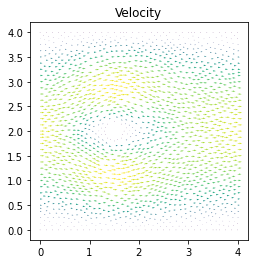

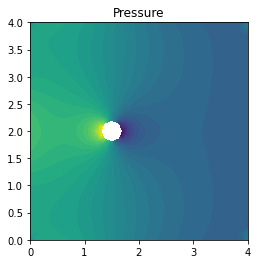

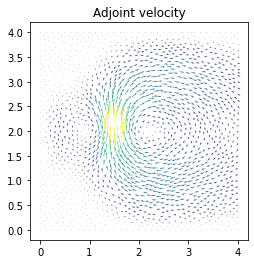

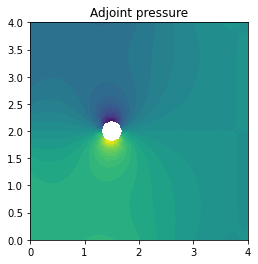

In [144]:
!rm results-NS/*

# Open files to export solution to Paraview
file_u = File("results-Stokes/u.pvd")
file_p = File("results-Etokes/p.pvd")
file_phi = File("results-Stokes/phi.pvd")
file_theta = File("results-Etokes/theta.pvd")

# Initiate functions to save and visualize the solutions
u_fcn = project(u, V)
p_fcn = project(p, Q)
phi_fcn = project(phi, V)
theta_fcn = project(theta, Q)

# Save solution to file
file_u << u_fcn
file_p << p_fcn
file_phi << phi_fcn
file_theta << theta_fcn

# Plot solution
plt.figure()
plot(u_fcn, title="Velocity")

plt.figure()
plot(p_fcn, title="Pressure")

plt.figure()
plot(phi_fcn, title="Adjoint velocity")

plt.figure()
plot(theta_fcn, title="Adjoint pressure")
        
plt.show()

# Export files
#!tar -czvf results-Stokes.tar.gz results-NS
#files.download('results-Stokes.tar.gz')

**Compute error indicators**

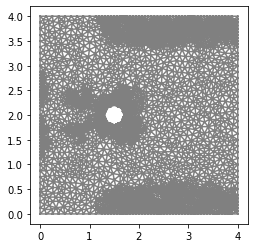

Total error = 9.830851132587174e-06


In [145]:
# Define function space over the elements of the mesh
WDG = FunctionSpace(W.mesh(), "DG", 0)
elm = TestFunction(WDG)
err_ind = Function(WDG)

# Compute local error indicators over the cells of the mesh 
local_error = ( elm*inner(f, phi)*dx + elm*p*div(phi)*dx - elm*inner(grad(u), grad(phi))*dx - elm*div(u)*theta*dx ) 
err_ind.vector()[:] = assemble(local_error)
err_ind_abs = np.abs(err_ind.vector())
err_ind_mean = err_ind_abs.sum()/err_ind.vector().size()

# Local mesh refinement (specified by a cell marker)
no_levels = 1
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for c in cells(mesh):
    cell_marker[c] = False
    local_error_cell = err_ind_abs[c.index()] 
    if local_error_cell > err_ind_mean:
        cell_marker[c] = True
  mesh = refine(mesh, cell_marker)

plt.figure()
plot(mesh)
plt.show()

err_ind_sum = ( inner(f, phi)*dx + p*div(phi)*dx - inner(grad(u), grad(phi))*dx - div(u)*theta*dx - 
               gamma*(ib*inner(u - uin, phi) + wb*inner(u, phi) + bb*inner(u, phi))*ds )

tot_err = assemble(err_ind_sum)
s = 'Total error = ' + repr(tot_err) 
print(s)

I ran the notebook with different resolutions and obtained the following total error indicators.

|Resolution|Total error|
|-|-|
|24|-8.1e-4|
|30|-2.6e-4|
|31|5.6e-4|
|32|9.8e-6|
|33|4.0e-4|
|34|-2.5e-4|
|48|2.4e-4|

# **Discussion**

A adaptive finite element method was implemented in FEniCS to solve the Stokes equations in 2D. An adjoint problem was defined with respect to different linear functionals, after which the residual and the solution to the adjoint was used to define an error indicator over the mesh.

When using a functional corresponding to the drag force, the adjoint pressure is high in front of the circle and low behind the circle. The mesh is refined in an "avocado shape" around the circle pointing in the reverse flow direction. Moving the circle means that the refinement moves with it. There is also some refinement near the boundary above and below the circle.

When using the functional corresponding to the lift force instead, the adjoint pressure is high below the circle and low above it. The mesh is still refined around the circle, but in a smaller area and another shape. The refinement at the top and bottom boundaries has expanded instead and now continues all the way to the right boundary.

If the same approximation spaces are used for both the primal and adjoint problem, the total error indicator becomes (close to) zero. We use different spaces and thus the indicator can be used to estimate the error in the solution. Generally, the total error decreases with finer resolution. However, there is a discontinuity at resolution 32, where the error is abnormally low for some reason.